- https://www.kaggle.com/tanlikesmath/intro-aptos-diabetic-retinopathy-eda-starter
- https://medium.com/@btahir/a-quick-guide-to-using-regression-with-image-data-in-fastai-117304c0af90

# params

In [8]:
PRFX = 'Dev070211'
p_o = f'../output/{PRFX}'

SEED = 111

dbg = True
if dbg:
    dbgsz = 500

BS = 128
SZ = 224
FP16 = False

import multiprocessing
num_workers=multiprocessing.cpu_count() # 2
num_workers=0


from fastai.vision import *
xtra_tfms = []
# xtra_tfms += [rgb_randomize(channel=i, thresh=1e-4) for i in range(3)]

params_tfms = dict(
     do_flip=True,
     flip_vert=False,
     max_rotate=10,
     max_warp=0,
     max_zoom=1.1,
     p_affine=0.5,
     max_lighting=0.2,
     p_lighting=0.5,
     xtra_tfms=xtra_tfms)

resize_method = ResizeMethod.CROP
padding_mode = 'zeros'

USE_TTA = True

# setup

In [9]:
import fastai
print('fastai.__version__: ', fastai.__version__)

import random 
import numpy as np
import torch
import os

def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_torch_seed()

fastai.__version__:  1.0.54


In [10]:
from fastai import *
from fastai.vision import *
import pandas as pd

import scipy as sp
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

# preprocess

In [11]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1])  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [12]:
img2grd += img2grd_blnd
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

In [13]:
if np.all([Path(o[0]).exists() for o in img2grd]): print('All files are here!')

All files are here!


In [14]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target']

df.shape

(3662, 2)

In [15]:
set_torch_seed()
idx_blnd_train = np.where(df.fnm.str.contains('aptos2019-blindness-detection/train_images'))[0]
idx_val = np.random.choice(idx_blnd_train, len_blnd_test, replace=False)
df['is_val']=False
df.loc[idx_val, 'is_val']=True

if dbg:
    df=df.head(dbgsz)

# dataset

In [16]:
tfms = get_transforms(**params_tfms)

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_from_df(col='is_val') 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data= (src.transform(tfms,
                         size=sz,
                         resize_method=resize_method,
                         padding_mode=padding_mode) #Data augmentation
            .databunch(bs=bs,num_workers=num_workers) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

bs = BS 
sz = SZ
data = get_data(sz, bs)

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

# model

In [18]:
%%time
# Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth

# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
!cp '../input/pytorch-vision-pretrained-models/resnet50-19c8e357.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

CPU times: user 6.39 ms, sys: 40.7 ms, total: 47 ms
Wall time: 985 ms


In [19]:
learn = cnn_learner(data, 
                    base_arch = models.resnet50, 
                    path=p_o)
learn.loss = MSELossFlat
if FP16: learn = learn.to_fp16()

In [20]:
%%time
learn.freeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 38min 42s, sys: 7min 31s, total: 46min 13s
Wall time: 35min 42s


Min numerical gradient: 2.29E-02
Min loss divided by 10: 1.45E-02


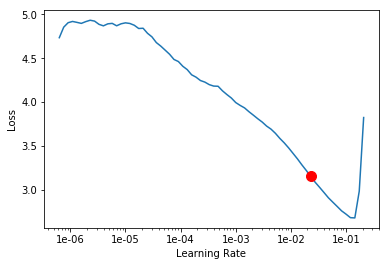

In [21]:
learn.recorder.plot(suggestion=True)

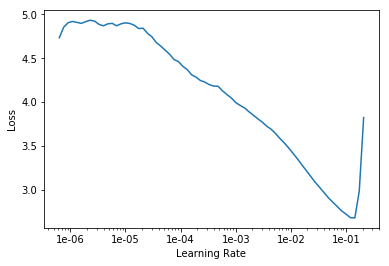

In [22]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr = 1e-2)

epoch,train_loss,valid_loss,mean_squared_error,time


In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.save('mdl-frozen')

In [ ]:
learn.unfreeze()

In [ ]:
%%time
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [25]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-3))


epoch,train_loss,valid_loss,mean_squared_error,time


KeyboardInterrupt: 

In [26]:
!nvidia-smi

Tue Jul  2 14:59:35 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    32W / 250W |   6289MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [27]:
learn.save('mdl')

# thresholding

In [28]:
%%time
preds_val, y_val = learn.TTA(ds_type=DatasetType.Valid)

RuntimeError: "sum_cpu" not implemented for 'Half'

In [29]:
preds_val = preds_val.numpy().squeeze()

y_val= y_val.numpy()

np.save(f'{p_o}/preds_val.npy', preds_val)
np.save(f'{p_o}/y_val.npy', y_val)

NameError: name 'preds_val' is not defined

In [ ]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/88773#latest-515044
# We used OptimizedRounder given by hocop1. https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
# put numerical value to one of bins
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class Hocop1OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [ ]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
class AbhishekOptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [ ]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [ ]:
optnm2coefs = {'simple': [0.5, 1.5, 2.5, 3.5]}

In [ ]:
%%time
optR = Hocop1OptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['hocop1'] = optR.coefficients()

In [ ]:
%%time
optR = AbhishekOptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['abhishek'] = optR.coefficients()

In [ ]:
optnm2coefs

In [ ]:
optnm2preds_val_grd = {k: bucket(preds_val, coef) for k,coef in optnm2coefs.items()}

optnm2qwk = {k: quadratic_weighted_kappa(y_val, preds) for k,preds in optnm2preds_val_grd.items()}

In [ ]:
optnm2qwk

In [ ]:
Counter(y_val).most_common()

In [ ]:
optnm2preds_val_grd['abhishek'].squeeze().mean()

In [ ]:
Counter(optnm2preds_val_grd['abhishek'].squeeze()).most_common()

In [ ]:
list(zip(optnm2preds_val_grd['abhishek'], y_val))[:10]

In [ ]:
(optnm2preds_val_grd['abhishek'].squeeze()== y_val.squeeze()).mean()

In [ ]:
pickle.dump(optnm2qwk, open(f'{p_o}/optnm2qwk.p', 'wb'))
pickle.dump(optnm2coefs, open(f'{p_o}/optnm2coefs.p', 'wb'))

# testing

This goes to Kernel!!

## params

In [ ]:
PRFX = ''
p_o = '.'

SEED = 111

dbg = True
if dbg:
    dbgsz = 500

BS = 128
SZ = 224
FP16 = True

from fastai.vision import *
xtra_tfms = []
# xtra_tfms += [rgb_randomize(channel=i, thresh=1e-4) for i in range(3)]

params_tfms = dict(
     do_flip=True,
     flip_vert=False,
     max_rotate=10,
     max_warp=0,
     max_zoom=1.1,
     p_affine=0.5,
     max_lighting=0.2,
     p_lighting=0.5,
     xtra_tfms=xtra_tfms)

resize_method = ResizeMethod.CROP
padding_mode = 'zeros'

USE_TTA = True

In [30]:
import fastai
fastai.__version__

'1.0.54'

## setup

In [31]:
from fastai import *
from fastai.vision import *
import pandas as pd


## preprocess

In [33]:
img2grd = []

In [34]:
p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1])  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [35]:
img2grd += img2grd_blnd
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

In [36]:
if np.all([Path(o[0]).exists() for o in img2grd]): print('All files are here!')

All files are here!


In [37]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target']

df.shape

(3662, 2)

In [38]:
df.head()

,fnm,target
0,../input/aptos2019-blindness-detection/train_i...,2
1,../input/aptos2019-blindness-detection/train_i...,4
2,../input/aptos2019-blindness-detection/train_i...,1
3,../input/aptos2019-blindness-detection/train_i...,0
4,../input/aptos2019-blindness-detection/train_i...,0


In [39]:
set_torch_seed()
idx_blnd_train = np.where(df.fnm.str.contains('aptos2019-blindness-detection/train_images'))[0]
idx_val = np.random.choice(idx_blnd_train, len_blnd_test, replace=False)
df['is_val']=False
df.loc[idx_val, 'is_val']=True

In [40]:
if dbg:
    df=df.head(dbgsz)

## dataset

In [42]:
tfms = get_transforms(**params_tfms)

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_from_df(col='is_val') 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data= (src.transform(tfms,
                         size=sz,
                         resize_method=resize_method,
                         padding_mode=padding_mode) #Data augmentation
            .databunch(bs=bs,num_workers=2) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

bs = BS 
sz = SZ
data = get_data(sz, bs)

## model

In [43]:
%%time
# Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth

# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
!cp '../input/pytorch-vision-pretrained-models/resnet50-19c8e357.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

CPU times: user 0 ns, sys: 36 ms, total: 36 ms
Wall time: 736 ms


In [44]:
learn = cnn_learner(data, 
                    base_arch = models.resnet50, 
                    metrics = [mse], 
                    path=p_o)
learn.loss = MSELossFlat
if FP16: learn = learn.to_fp16()
learn = learn.load('mdl')

In [45]:
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
df_test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [46]:
learn.data.add_test(
    ImageList.from_df(df_test,
                      '../input/aptos2019-blindness-detection',
                      folder='test_images',
                      suffix='.png'))

In [ ]:
%%time
# Predictions for test set
preds_tst, _ = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
preds_tst =  preds_tst.numpy()

In [ ]:
preds_tst.shape

In [ ]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [ ]:
optnm2qwk = pickle.load(open(f'{p_o}/optnm2qwk.p','rb'))
optnm2coefs = pickle.load(open(f'{p_o}/optnm2coefs.p','rb'))

In [ ]:
optnm2qwk, optnm2coefs

In [ ]:
coef = optnm2coefs['abhishek']
preds_tst_grd = bucket(preds_tst, coef)

In [ ]:
preds_tst_grd.squeeze()

In [ ]:
Counter(preds_tst_grd.squeeze()).most_common()

## submit

In [ ]:
subm = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
subm['diagnosis'] = preds_tst_grd.squeeze().astype(int)
subm.head()

In [ ]:
subm.diagnosis.value_counts()

In [ ]:
subm.to_csv(f"{p_o}/submission.csv", index=False)